# Dataset 1 - Adult Data Set

## Data loading and processing

Load the dataset form 'adult.data'. Convert categorical features into numbers and convert missing values into -1.

In [1]:
import numpy as np

#feature names and categorical features
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
category_features = np.array([1,3,5,6,7,8,9,13])
categories = {'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
              'education': ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
              'marital-status': ['Married-civ-spouse', 'Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'],
              'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', 'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', 'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing','Transport-moving', 'Priv-house-serv', 'Protective-serv', 'Armed-Forces'],
              'relationship': ['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'],
              'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
              'sex': ['Female', 'Male'],
              'native-country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico', 'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India', 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras', 'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico', 'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', 'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala', 'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador', 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']}
    
#Convert categorical features into numbers and convert missing values into -1.
def find_category(string, index):
    l = categories[features[index]]
    if string in l:
        return l.index(string)
    return -1

converters = {}
for i in category_features:
    def lambda_generator(i):
       return lambda s: find_category(s.strip(), i)
    converters[i] = lambda_generator(i)
converters[len(features)] = lambda s: 1 if '>50K' in s else 0

data = np.loadtxt('./adult.data', dtype=int, encoding='utf-8-sig', delimiter=', ', converters=converters)
print('The shape of the dataset is', data.shape)

The shape of the dataset is (32561, 15)


Clean the Data.

Remove instances that have 3 or more missing data entries.

Impute missing values with most frequent value of each column.

In [2]:
#clean the traing data

from sklearn.impute import SimpleImputer

def imputate_data(X):
    #delete rows which contain 3 or more missing data points
    missing_count = np.count_nonzero(X == -1, axis=1)
    X = np.delete(X, np.where(missing_count>2), axis=0)
    #Impute missing values with most frequent value of each column.
    imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
    return imp.fit_transform(X)

data = imputate_data(data)
print('The shape of the dataset after cleaning is', data.shape)


The shape of the dataset after cleaning is (32534, 15)


In [3]:
#one-hot-coding

from sklearn.preprocessing import OneHotEncoder

def one_hot_coding(X):
    X_categories = X[:,category_features]
    c = list()
    for i in category_features: c.append(np.arange(len(categories[features[i]])))
    enc = OneHotEncoder(categories=c, dtype=int)
    enc.fit(X_categories)
    X_categories = enc.fit_transform(X_categories).toarray()
    X = np.delete(X, category_features, axis=1)
    return np.concatenate((X, X_categories), axis = 1)

#seperate X and y from data
y_train = data[:, -1]
X_train = np.delete(data, -1, axis=1)

X_train = one_hot_coding(X_train)
print('The shape of the dataset after one-hot coding is', X_train.shape)


The shape of the dataset after one-hot coding is (32534, 105)


## Visualize the distribution of data.

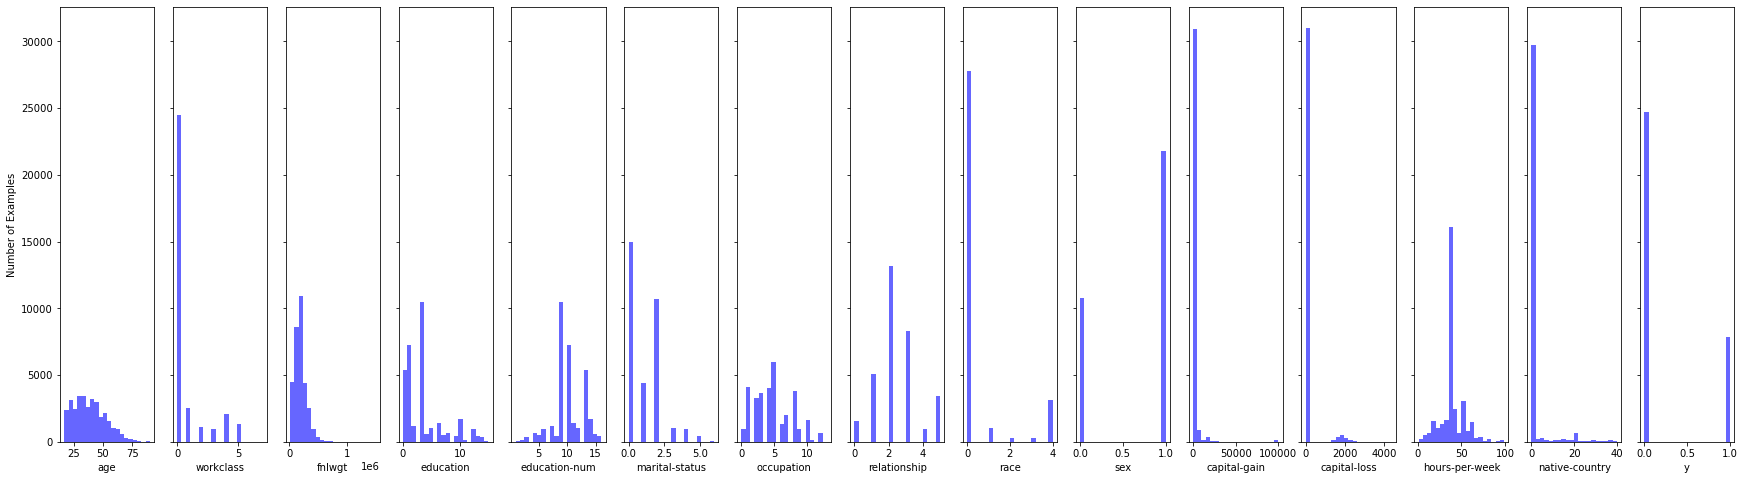

In [4]:
import matplotlib.pyplot as plt 

fig, axs = plt.subplots(1, data.shape[1], sharey=True)
fig.set_size_inches(30, 8)
for i, ax in enumerate(axs):
    ax.hist(data[:, i], 20, facecolor='b', alpha=0.6)
    if i<len(features): ax.set_xlabel(f'{features[i]}')
    else: ax.set_xlabel(f'y')
axs[0].set_ylabel('Number of Examples')
plt.show()


NameError: name 'feature_names' is not defined

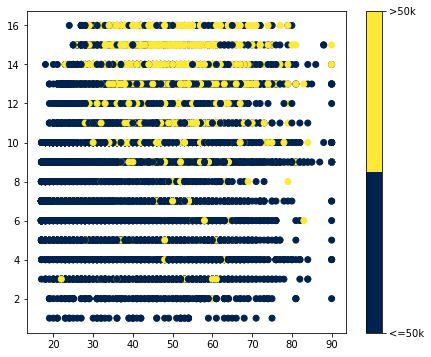

In [5]:
plt.figure(figsize=(18, 10))
for pairidx, pair in enumerate([[0,2], [0,5], [2,5], [0,1], [1,2], [1,5]]):
    plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    x1_index, x2_index = pair[0], pair[1]
    formatter = plt.FuncFormatter(lambda i, *args: '>50k' if i==1 else '<=50k')
    plt.scatter(X_train[:,x1_index], X_train[:,x2_index], c=y_train, cmap=plt.cm.get_cmap('cividis',2))
    plt.colorbar(ticks=[0,1], format=formatter)
    plt.xlabel(feature_names[x1_index])
    plt.ylabel(feature_names[x2_index])

## KNN

### Use 5-fold cross-validation to pick the best K value of KNN model

In [6]:
#CV implementation
import math
def cross_validation(model, X, y, k_fold = 5):
    """
    method: cross_validation
    params: Model(object used to fit data) model
      numpy array (array-like) Data X
      numpy array (array-like) Labels y
      int k_fold (default value set to 5)
    return: A tuple containing the Model(Final Model with best accuracy) final_model and float best_accuracy - average validation accuracy
    """
    best_accuracy = 0
    start = math.ceil((X.shape[0]/k_fold)*(k_fold-1))
    end = X.shape[0]
    model_accuracies = list()

   # shuffle the training data
    #np.random.seed(1)
    #np.random.shuffle(X)
    #np.random.seed(1)
    #np.random.shuffle(y)
    
    X, y = shuffle(X, y)

    # k_fold
    for i in range(k_fold):

        # split into training and validation data
        validation_X = X.iloc[start: end]
        validation_y = y.iloc[start: end]

        training_X = X[~X.index.isin(validation_X.index)]
        training_y = y[~y.index.isin(validation_y.index)]
        #training_X = np.setdiff1d(X, validation_X)
        #training_y = np.setdiff1d(y, validation_y)

        # fit the model
        model.fit(training_X, training_y)

        # predict on validation data
        y_pred = model.predict(validation_X)
        acc = np.mean(y_pred == validation_y)
        model_accuracies.append(acc)

        # pick the model with the best accuracy
        #if acc > best_accuracy:
        #    best_accuracy = acc
        #    final_model = model

        end = start
        start = math.ceil(start - (X.shape[0]/k_fold))

    return np.mean(model_accuracies)

In [11]:
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

def train_KNN(X,y):
    best_acc = 0
    accuracy = np.zeros(50)
    #enumerate the value of K
    for n_neighbors in np.arange(1,20):
        knn_model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
        #find the best 5-fold cross validation score accuracy
        acc = cross_val_score(knn_model, X, y, cv=5).mean()
        accuracy[n_neighbors] = acc
        if acc > best_acc:
            best_K = n_neighbors
            best_acc = acc
            best_knn_model = knn_model
    return best_knn_model, best_acc, best_K

In [12]:
%%time

best_knn_model, best_acc, best_K = train_KNN(X_train, y_train)
print(f'best cross validation accuracy : {best_acc:.3f} when K= {best_K}')

best cross validation accuracy : 0.798 when K= 18
Wall time: 4min 41s


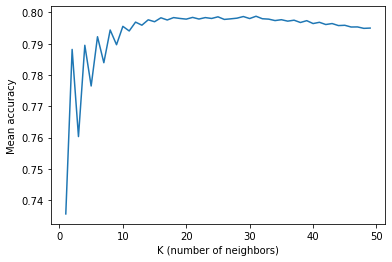

In [104]:
plt.plot(range(1,50), accuracy[1:])
plt.ylabel('Mean accuracy')
plt.xlabel('K (number of neighbors)')
plt.show()

### Prediction

In [13]:
#load test data
test = np.loadtxt('./adult.test', dtype=int, encoding='utf-8-sig', delimiter=', ', skiprows=1, converters=converters)
#clear the data
test = imputate_data(test)
#seperate X and y of test data
y_test = test[:, -1]
X_test = np.delete(test, -1, axis=1)
#do one-hot-coding
X_test = one_hot_coding(X_test)
print('The shape of the testset is', X_test.shape)

The shape of the testset is (16262, 105)


In [16]:
%%time

#prediction
best_knn_model.fit(X_train, y_train)
y_pred = best_knn_model.predict(X_test)
test_acc = np.mean(y_pred == y_test)
print('The accuracy of KNN model with K=', best_K, 'is ', f'{test_acc:.4f}')

The accuracy of KNN model with K= 18 is  0.8015
Wall time: 9.23 s


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ModuleNotFoundError: No module named 'seaborn'

### Observe the effect of the dataset size

The accuracy is  0.7851 when dataset size is 2033
The accuracy is  0.7893 when dataset size is 4066
The accuracy is  0.7939 when dataset size is 8133
The accuracy is  0.7987 when dataset size is 16267


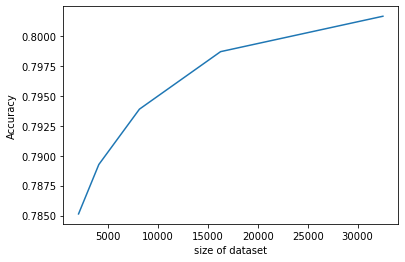

In [115]:
accuracy = np.zeros(5)
sub = np.array([16,8,4,2,1])

for i in range(sub.size - 1):
    #get subset of training data
    size = X_train.shape[0] // sub[i]
    X_train_sub = X_train[:size,:]
    y_train_sub = y_train[:size]
    #train
    best_knn_model, best_acc, best_K = train_KNN(X_train_sub, y_train_sub)
    #prediction
    best_knn_model.fit(X_train_sub, y_train_sub)
    y_pred = best_knn_model.predict(X_test)
    acc = np.mean(y_pred == y_test)
    print('The accuracy is ',f'{acc:.4f}', 'when dataset size is', size)
    accuracy[i] = acc
accuracy[sub.size-1] = test_acc
plt.plot(X_train.shape[0] // sub, accuracy)
plt.ylabel('Accuracy')
plt.xlabel('size of dataset')
plt.show()

## Desicion Tree

### Use 5-fold cross-validation to pick the best parameters (max_depth, min_samples_leaf, min_impurity_decrease)

In [17]:
from sklearn.tree import DecisionTreeClassifier


def train_Decision_Tree(X,y):
    #choices of hyperparameter 
    max_depth_values = np.arange(12,18)
    min_samples_leaf_values = np.arange(2,6) * 2
    min_impurity_decrease_values = np.arange(5,10) * 0.00002
    
    total_models = max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size
    accuracy = np.zeros(max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size).reshape(max_depth_values.size, min_samples_leaf_values.size, min_impurity_decrease_values.size)
    best_acc = 0
    cur_per, count = -1, 0

    #try all hyperparameter combinations
    for max_depth in range(max_depth_values.size):
        for min_samples_leaf in  range(min_samples_leaf_values.size):
            for min_impurity_decrease in range(min_impurity_decrease_values.size):
                clf = DecisionTreeClassifier(max_depth=max_depth_values[max_depth], min_samples_leaf=min_samples_leaf_values[min_samples_leaf], min_impurity_decrease=min_impurity_decrease_values[min_impurity_decrease])
                #find the best 5-fold cross validation score accuracy
                acc = cross_val_score(clf, X_train, y_train, cv=5).mean()
                accuracy[max_depth, min_samples_leaf, min_impurity_decrease] = acc
                if acc > best_acc:
                    best_cfg = (max_depth_values[max_depth], min_samples_leaf_values[min_samples_leaf], min_impurity_decrease_values[min_impurity_decrease])
                    best_acc = acc
                    best_decision_tree_model = clf
    return best_decision_tree_model, best_acc, best_cfg

In [19]:
%%time

best_decision_tree_model, best_acc, best_cfg = train_Decision_Tree(X_train, y_train)
print(f'best cross validation accuracy : {best_acc:.3f} \nwhen max_depth_values, min_samples_leaf_values, min_impurity_decrease_values= {best_cfg}')

best cross validation accuracy : 0.860 
when max_depth_values, min_samples_leaf_values, min_impurity_decrease_values= (15, 8, 0.00012000000000000002)
Wall time: 1min 46s


### Visualize the best tree

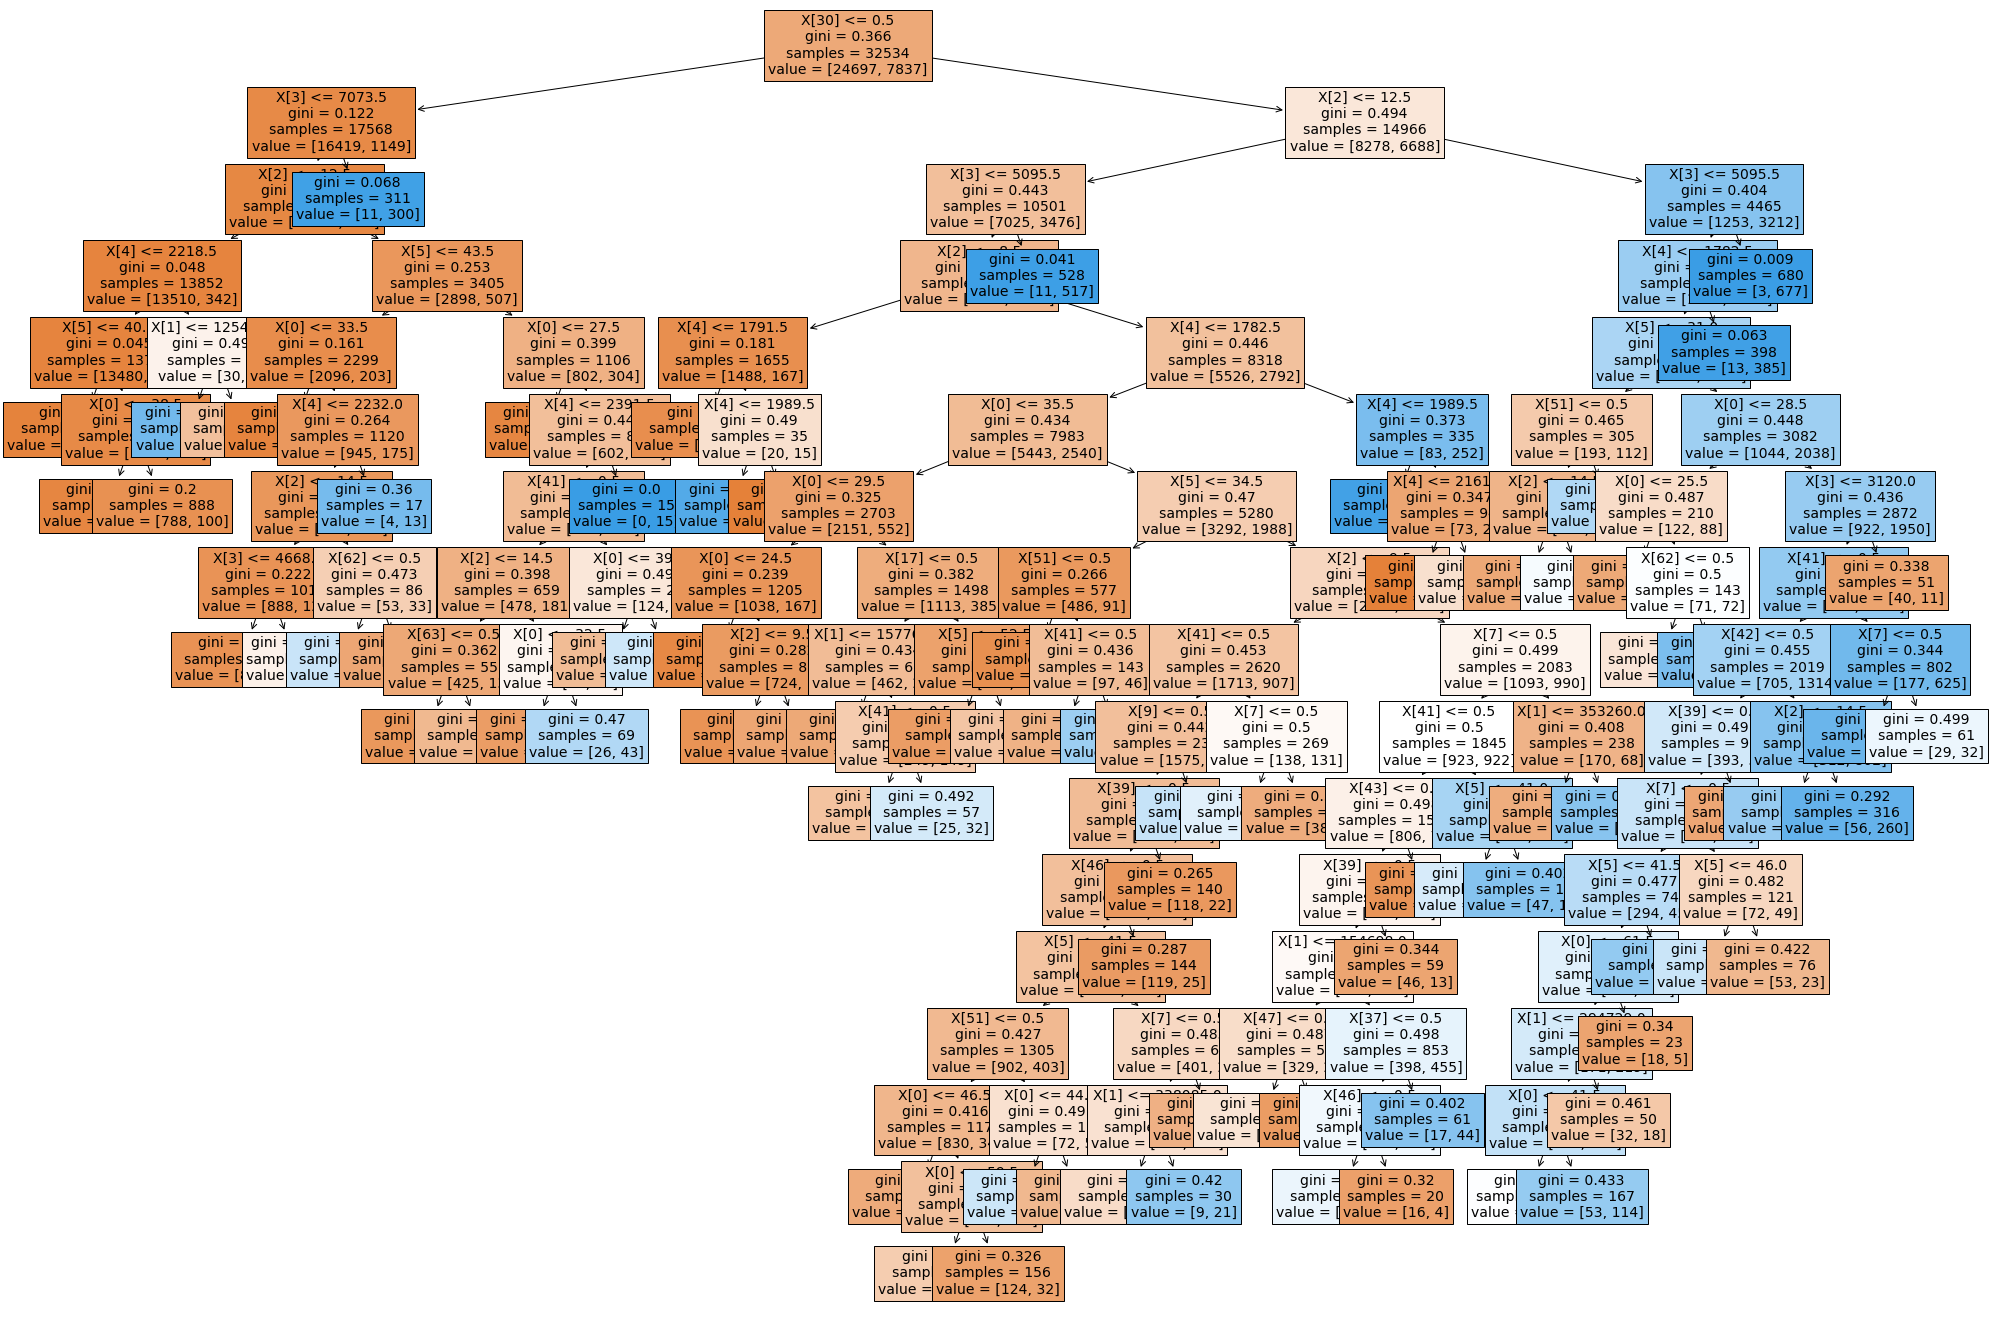

In [124]:
from sklearn.tree import plot_tree
best_decision_tree_model.fit(X_train, y_train)
plt.figure(figsize=(34,24))
plot_tree(best_decision_tree_model, filled=True, fontsize=14)
plt.show()

### Testing

In [131]:
best_decision_tree_model.fit(X_train, y_train)
y_pred = best_decision_tree_model.predict(X_test)
test_acc = np.mean(y_pred == y_test)
print('accuracy = ', f'{test_acc:.4f}')

accuracy =  0.8611


<AxesSubplot:>

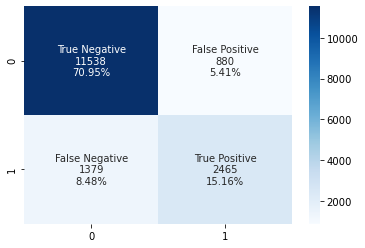

In [132]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred)
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

### Observe the effect of the dataset size

The accuracy is  0.8345 when dataset size is 2033
The accuracy is  0.8357 when dataset size is 4066
The accuracy is  0.8397 when dataset size is 8133
The accuracy is  0.8554 when dataset size is 16267


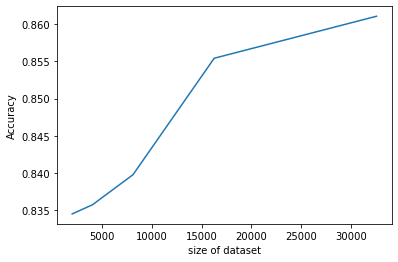

In [136]:
accuracy = np.zeros(5)
sub = np.array([16,8,4,2,1])

for i in range(sub.size - 1):
    #get subset of training data
    size = X_train.shape[0] // sub[i]
    X_train_sub = X_train[:size,:]
    y_train_sub = y_train[:size]
    #train
    best_decision_tree_model, best_acc, best_cfg = train_Decision_Tree(X_train_sub, y_train_sub)
    #prediction
    best_decision_tree_model.fit(X_train_sub, y_train_sub)
    y_pred = best_decision_tree_model.predict(X_test)
    acc = np.mean(y_pred == y_test)
    print('The accuracy is ',f'{acc:.4f}', 'when dataset size is', size)
    accuracy[i] = acc
    
accuracy[sub.size-1] = test_acc
plt.plot(X_train.shape[0] // sub, accuracy)
plt.ylabel('Accuracy')
plt.xlabel('size of dataset')
plt.show()

# Dataset 2 - Student Performance

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle

## Data Prep

In this dataset, we're given the data of 649 Portuguese students and asked to predict their final trimester grades (G3) in math.

The dataset has no missing data, so there's no imputation involved.

Data source: https://archive.ics.uci.edu/ml/datasets/Student+Performance

In [21]:
df = pd.read_csv('./student-mat.csv', sep=';')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [22]:
#split df into categorical and numerical features
cat_df = df.select_dtypes(include='object')
num_df = df.select_dtypes(include='int64')

onehot_df = pd.DataFrame.copy(df)

for feature in cat_df.columns:
    onehot_cols = pd.get_dummies(df[feature], prefix=feature)
    
    onehot_df = onehot_df.drop(columns=feature)
    onehot_df = pd.concat([onehot_df, onehot_cols], axis=1)

In [23]:
onehot_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,0,1,0,1,1,0,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,0,1,0,1,1,0
2,15,1,1,1,2,3,4,3,2,2,...,1,0,0,1,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,0,1,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,0,1,0,1,1,0,1,0


In the Portuguese grading system, a score of 10+ is a pass. Let's make things a bit simpler for our decision trees and try to predict if a student passes or fails in the third semester. 

To do that, we turn the G3 column into a binary one.

In [24]:
#But first, make sure our classes are sufficiently populated
onehot_df.loc[onehot_df.G3 < 10].shape

(130, 59)

Almost a fifth of the students failed :(

In [25]:
onehot_df.loc[onehot_df.G3 < 10, 'G3'] = 0
onehot_df.loc[onehot_df.G3 >= 10, 'G3'] = 1

onehot_df.G3.head()

0    0
1    0
2    1
3    1
4    1
Name: G3, dtype: int64

Before we train, let's split off 20% of the data for testing.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(onehot_df.drop(columns='G3'), onehot_df.G3, test_size=0.2, random_state=42)

## Training

### KNN

Let's find a best KNN model. All the code here is Elvin's. Thank you!

In [27]:
k_values = np.arange(1, 50)

best_acc = 0
accuracy = np.zeros(50)

from sklearn.model_selection import cross_val_score

for n_neighbors in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    #find the best 5-fold cross validation score accuracy
    acc = cross_validation(knn_model, X_train, y_train)
    accuracy[n_neighbors] = acc
    if acc > best_acc:
        best_K = n_neighbors
        best_acc = acc
        best_knn = knn_model

In [28]:
best_acc

0.8984126984126984

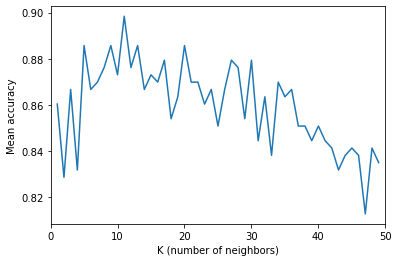

In [29]:
plt.plot(k_values, accuracy[1:])
plt.xlim(0,50)
#plt.ylim(0.7,0.8)
plt.ylabel('Mean accuracy')
plt.xlabel('K (number of neighbors)')
plt.show()

### Decision Tree

Now let's find a best decision tree. It's a wee bit more complicated, since there is so much space to search through. Potentially we could search through an extensive list of combinations: 

Most of the code is Elvin's again.

In [30]:
#choices of hyperparameter 
max_depth_values = np.arange(5, 16)
min_samples_leaf_values = np.arange(10,40) * 2
min_impurity_decrease_values = np.arange(20) * 0.00002


total_models = max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size
accuracy = np.zeros(max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size).reshape(max_depth_values.size, min_samples_leaf_values.size, min_impurity_decrease_values.size)
best_acc = 0
cur_per, count = -1, 0

#try all hyperparameter combinations
for max_depth in range(max_depth_values.size):
    for min_samples_leaf in  range(min_samples_leaf_values.size):
        for min_impurity_decrease in range(min_impurity_decrease_values.size):
            clf = DecisionTreeClassifier(max_depth=max_depth_values[max_depth], min_samples_leaf=min_samples_leaf_values[min_samples_leaf], min_impurity_decrease=min_impurity_decrease_values[min_impurity_decrease])
            #find the best 5-fold cross validation score accuracy
            acc = cross_val_score(clf, X_train, y_train, cv=5).mean()
            accuracy[max_depth, min_samples_leaf, min_impurity_decrease] = acc
            if acc > best_acc:
                best_cfg = (max_depth_values[max_depth], min_samples_leaf_values[min_samples_leaf], min_impurity_decrease_values[min_impurity_decrease])
                best_acc = acc
                best_tree = clf

In [31]:
print(best_acc, best_cfg)

0.9207341269841269 (5, 20, 0.0)


## Prediction

Let's predict these students' G3 grades using their earlier grades and other details.

In [34]:
best_tree.fit(X_train, y_train)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [35]:
tree_pred = best_tree.predict(X_test)
knn_pred = best_knn.predict(X_test)

In [51]:
metrics.accuracy_score(y_test, knn_pred)

0.8987341772151899

In [53]:
metrics.confusion_matrix(y_test, knn_pred)

array([[23,  4],
       [ 4, 48]], dtype=int64)

KNN doesn't do very bad.

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_pred)
metrics.auc(fpr, tpr)

0.8874643874643875

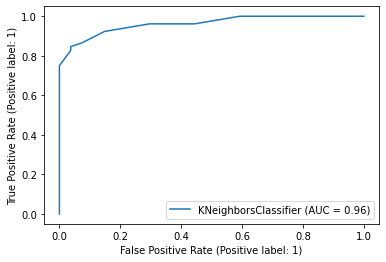

In [37]:
metrics.plot_roc_curve(best_knn, X_test, y_test)

But it looks like decision tree is a winner.

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, tree_pred)
metrics.auc(fpr, tpr)

0.9237891737891738

In [52]:
metrics.accuracy_score(y_test, tree_pred)

0.9113924050632911

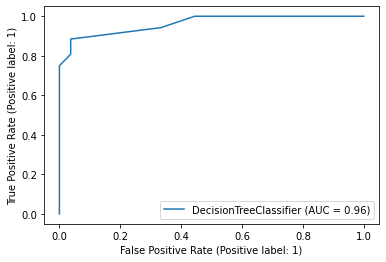

In [39]:
metrics.plot_roc_curve(best_tree, X_test, y_test)

## Feature selection experiments

Intuitively and as noted in the dataset description, previous grades are the most useful predictor for the final grade. And indeed, it looks like the reason our tree does well is simply because it checks whether the student passed the last trimester.

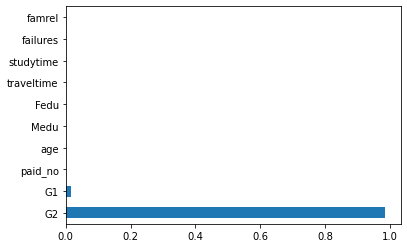

In [40]:
feat_importances = pd.Series(best_tree.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Let's drop the previous grades and see what happens to our tree.

In [41]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(onehot_df.drop(columns=['G3', 'G2', 'G1']), onehot_df.G3, test_size=0.2, random_state=42)

no_grade_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_impurity_decrease=0.0)

no_grade_tree.fit(X_train_new, y_train_new)
pred = no_grade_tree.predict(X_test_new)
fpr, tpr, thresholds = metrics.roc_curve(y_test_new, pred)
metrics.auc(fpr, tpr)

0.5705128205128205

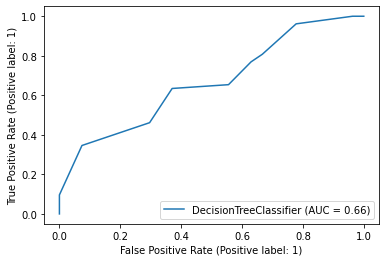

In [43]:
metrics.plot_roc_curve(no_grade_tree, X_test_new, y_test_new)

Oof. Without grades, what's predicting the students' performance?

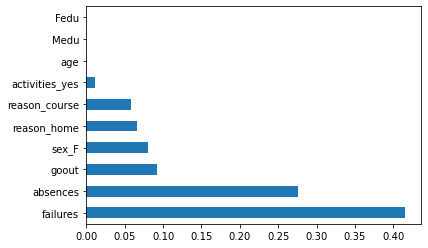

In [45]:
feat_importances = pd.Series(no_grade_tree.feature_importances_, index=X_test_new.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Previous failures and abscences from class. That makes sense, intuitively! Gender also seems to play a role, but our decision tree is somewhat bad, so it should be taken with a grain of salt.

All that said, our hyperparameters were optimized for a different dataset, so we might not be giving the tree its best shot. 

## Randomized Grid Search

Before we optimize the new tree, let's try a different method of hyperparameter search. Running through all the hyperparameter combos takes a long time, so let's try picking and testing random sets.

In [46]:
def random_tree_optimization(X_train, y_train):

    #choices of hyperparameter 
    max_depth_values = np.arange(5, 16)
    min_samples_leaf_values = np.arange(10,40) * 2
    min_impurity_decrease_values = np.arange(20) * 0.00002

    n_sets_to_sample = 20

    total_models = max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size
    #accuracy = np.zeros(max_depth_values.size * min_samples_leaf_values.size * min_impurity_decrease_values.size).reshape(max_depth_values.size, min_samples_leaf_values.size, min_impurity_decrease_values.size)
    best_acc = 0
    cur_per, count = -1, 0

    for i in range(n_sets_to_sample):

        max_depth = np.random.choice(max_depth_values)
        min_split = np.random.choice(min_samples_leaf_values)
        min_impurity = np.random.choice(min_impurity_decrease_values)

        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_split, min_impurity_decrease=min_impurity)
        #find the best 5-fold cross validation score accuracy
        acc = cross_val_score(clf, X_train, y_train, cv=5).mean()
        #accuracy[max_depth, min_samples_leaf, min_impurity_decrease] = acc
        if acc > best_acc:
            best_cfg = (max_depth, min_split, min_impurity)
            best_acc = acc
            best_tree = clf
            
    return best_cfg, best_acc, best_tree


In [47]:
best_cfg, best_acc, best_model = random_tree_optimization(X_train, y_train)

print(best_acc, best_cfg)

0.9207341269841269 (15, 40, 0.0001)


Very similar max accuracy to the thorough search, but also a different optimized hyperparameter set!

Let's use our new method to optimize the no grade tree.

In [48]:
best_cfg, best_acc, best_model_no_grade = random_tree_optimization(X_train_new, y_train_new)

best_model_no_grade.fit(X_train_new, y_train_new)
pred = best_model_no_grade.predict(X_test_new)
fpr, tpr, thresholds = metrics.roc_curve(y_test_new, pred)
metrics.auc(fpr, tpr)

0.6748575498575499

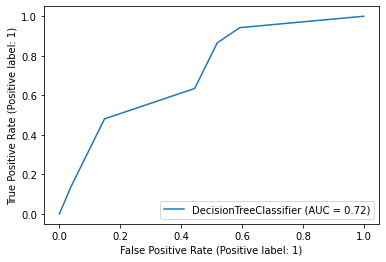

In [49]:
metrics.plot_roc_curve(best_model_no_grade, X_test_new, y_test_new)

Still not the best model in the world.

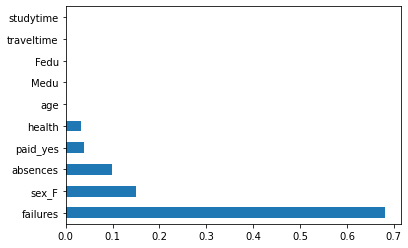

In [50]:
feat_importances = pd.Series(best_model_no_grade.feature_importances_, index=X_test_new.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Oh, hey, the feature importances changed in the better model! Failures, absences and gender are all important predictors, and health seems to play a role as well. All of them make some intuitive sense. 